# Create models from *Ergo* data
This notebook contains the code for models used to predict the *Ergo* data. See the report [here](https://git.cs.sun.ac.za/Computer-Science/rw771/2022/26723077-TG7-doc) or the source code behind the data [here](https://git.cs.sun.ac.za/Computer-Science/rw771/2022/26723077-TG7-src).

### Items to explore

- What is the optimal number of PCs for model performance?
- Which is the optimal dimensionality reduction method: tSNE, Autoencoder, PCA?
- Compare different model types: Random Forest, SVM, NN, Nïeve Bayes, Quadratic Discriminent Analysis
- Restructure this to have a better order
    - imports, get data, PCA on data, train model, visualise model's conf matrix, visualise model's mislabeled observations
- Note: The model might struggle with how gesture classification is independant of when the gesture was performed. How to modify training data to account for this? and how to verify that models aren't fixating on *when* a gesture happens, as opposed to *which* gestures happens?


- TODO: create a common method of scaling with a saved scaler before plotting the observation
- TODO: create a method of visualising how data flows through the MLP so you can troubleshoot misclassified real-time predictions
- TODO: indicate for a given model which observations were correctly predicted
- TODO: this should actually show the model activations for the actual and predicted gestures, and not just some random (maybe unrepresentative) example observation


### The overall process
0. Imports and constants, reading in data, scaling data
1. Find outliers via PCA
2. Remove outliers
3. Train many model on the full dimensionality dataset, and save them all
4. Evaluate ONE saved model
    - Confusion matrix
    - Plots of all incorrectly classified observations
    - Visualise important features
5. Self-classify some observations in real time
6. Audit how well the model predicts those real-time observations

## 0.1 Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

from common_utils import *

from time import time
from matplotlib import cm

# Preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Distributions
from sklearn.utils.fixes import loguniform

## 0.2 Read in the data to an `np.array`

In [11]:
X, y, paths = read_to_numpy()
n_classes = np.unique(y).shape[0]
n_obs = y.shape[0]
gesture_info = get_gesture_info()
with open('saved_models/idx_to_gesture.pickle', 'rb') as f:
    idx_to_gesture = pickle.load(f)
with open('saved_models/gesture_to_idx.pickle', 'rb') as f:
    gesture_to_idx = pickle.load(f)


10 gestures, 2063 total observations
  gesture0001: Left hand thumb IP flexion               (194 observations)
  gesture0002: Left hand index finger PIP flexion       (200 observations)
  gesture0003: Left hand middle finger PIP flexion      (195 observations)
  gesture0004: Left hand ring finger PIP flexion        (212 observations)
  gesture0005: Left hand little finger PIP flexion      (217 observations)
  gesture0006: Right hand thumb IP flexion              (205 observations)
  gesture0007: Right hand index finger PIP flexion      (195 observations)
  gesture0008: Right hand middle finger PIP flexion     (210 observations)
  gesture0009: Right hand ring finger PIP flexion       (225 observations)
  gesture0010: Right hand little finger PIP flexion     (210 observations)
done


In [18]:
x

10

In [26]:
idx_to_gestures

{0: 'gesture0001',
 1: 'gesture0002',
 2: 'gesture0003',
 3: 'gesture0004',
 4: 'gesture0005',
 5: 'gesture0006',
 6: 'gesture0007',
 7: 'gesture0008',
 8: 'gesture0009',
 9: 'gesture0010'}

## 0.3 Train-test split and scale the data

In [3]:
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split_scale(X, y, paths)
scaler = load_model("saved_models/StandardScaler().pickle")
print(f'{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')

X_train.shape=(1547, 1200)
X_test.shape=(516, 1200)
y_train.shape=(1547,)
y_test.shape=(516,)


In [31]:
scaler

StandardScaler()

# 1. Find any outliers via PCA

Saved as imgs/2_pca_10_classes_2063_obs.pdf


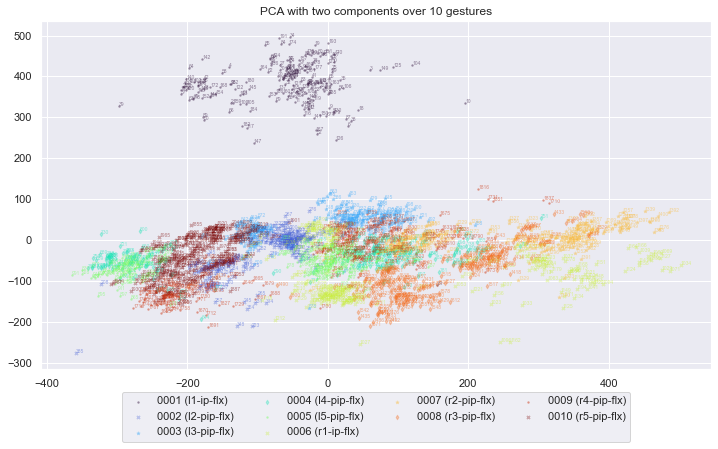

In [4]:
# PCA can be either 2D or 3D
PLOT_2D = True

# Transform the data via PCA. Either 2 or 3 components are used
pca = PCA(n_components=(2 if PLOT_2D else 3))
X_r = pca.fit(X).transform(X)

# Each observation gets a different colour on the scatter plot, and
# similar colours get different markers to better differentiate them
colours = cm.get_cmap('turbo', n_classes)
markers = ['.', 'x', '*', 'd']


if PLOT_2D:
    # Use 2D subplots
    fig, ax = plt.subplots(figsize=(12,8))
else:
    # Use 3D subplots
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

# Optionally also plot the observation indices along with the points.
# This helps when removing outliers, but increases the amount of clutter
if PLOT_2D:
    for i, yi in enumerate(y):
        ax.annotate(
            i, 
            (X_r[i, 0], X_r[i, 1]),
            color=colours(yi/n_classes),
            size=5,
            alpha=0.5,
        )

# Iterate over each label/gesture
for i, label_idx in enumerate(idx_to_gesture.keys()):
    # Args either has 2 items (if 2D) or 3 (if 3D)
    args = [
        X_r[y == label_idx, 0], 
        X_r[y == label_idx, 1],
    ]
    if not PLOT_2D:
        args.append(X_r[y == label_idx, 2])
    
    # Get a shortened version of the gesture index for the legend
    gesture_idx = idx_to_gesture[label_idx].replace('gesture', '')
    # Get the short gesture description for the legend
    gesture_desc = gesture_info[idx_to_gesture[label_idx]]["desc"]
    
    # Actually plot the points, either in 2 or 3 dimensions
    ax.scatter(
        *args,
        color=colours(label_idx/n_classes),
        alpha=0.3,
        s=10,
        marker=markers[label_idx % 4],
        label=f'{gesture_idx} ({gesture_desc})'
    )

# ----------------------------------------------------------------
#
#   modified from https://stackoverflow.com/a/4701285/14555505
#
# Shrink current axis's height by 10% on the bottom so the legend will fit
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.80])
# Put a legend below current axis in the newly made space
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
# ----------------------------------------------------------------

# Give the plot a title and save it
plt.title(f"PCA with {'two' if PLOT_2D else 'three'} components over {n_classes} gestures")
filename = f'imgs/{2 if PLOT_2D else 3}_pca_{n_classes}_classes_{n_obs}_obs.pdf'
plt.savefig(filename)
print(f'Saved as {filename}')

# 2. Remove outliers
This widget allows you to plot an observation along with its original path and other metadata.
After finding an outlier's observation index on the PCA plot, you can graph the actual observation
here. If it is actually an outlier, this widget will also give you the path of the original observation, 
from which you can remove the original csv file defining the observation and thereby remove it from the
dataset.

All paths are relative to the `ergo/machine_learning/` directory.

In [5]:
@interact(idx='0')
def plot_from_index(idx='0'):
    if len(idx) == 0:
        return
    idx = int(idx)
    gesture_idx = idx_to_gesture[y[idx]]
    plot_raw_gesture(
        X[idx],
        f'{gesture_idx}: {gesture_info[gesture_idx]["description"]}\n{paths[idx].split("/")[-1]}'
    )
    print(f'{gesture_info[gesture_idx]["description"]}')
    print('rm ' + paths[idx])

interactive(children=(Text(value='0', description='idx'), Output()), _dom_classes=('widget-interact',))

# 3.0 Train the MLP and save it


Training KNeighborsClassifier(n_neighbors=21)
- Time taken: 153.927s
- Best performing model
`KNeighborsClassifier(algorithm='ball_tree', n_neighbors=21)`
- Score: train: 0.9679, test: 0.9774


Training MLPClassifier(max_iter=1000)
- Time taken: 81.279s
- Best performing model
```MLPClassifier(activation='tanh', alpha=0.0013330009770265291, hidden_layer_sizes=400, max_iter=1000)```
- Score: train: 0.9907, test: 0.9947

Training MLPClassifier(max_iter=1000)
- Time taken: 27.189s
- Best performing model
`MLPClassifier(alpha=0.0016877545702567223, hidden_layer_sizes=100, max_iter=1000)`
- Score: train: 0.9903, test: 0.9950


In [7]:
%%time
models = []

models.append(
    (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(100), (200), (400), (100, 50), (200, 100), (400, 200), 
                               (100, 50, 25), (200, 100, 50), (400, 200, 100)],
        'activation' : ['logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'adam'],
        'alpha': loguniform(1e-6, 1e-2),
    })
)

clfs = []
for model, param_grid in models:
    print(f'\nTraining {model}')
    start = time()
    clf = RandomizedSearchCV(
        model, param_grid, n_iter=1
    )
    clf = clf.fit(X_train, y_train)
    print(f'- Time taken: {time() - start:.3f}s\n- Best performing model\n`{clf.best_estimator_}`\n- Score: train: {clf.best_score_:.4f}, test: {clf.score(X_test, y_test):.4f}')
    clfs.append(clf.best_estimator_)
    save_model(clf.best_estimator_)
    


Training MLPClassifier(max_iter=1000)
- Time taken: 89.496s
- Best performing model
`MLPClassifier(activation='logistic', alpha=0.002746441213266069,
              hidden_layer_sizes=400, max_iter=1000, solver='lbfgs')`
- Score: train: 0.9716, test: 0.9787
CPU times: user 11min 23s, sys: 2min 32s, total: 13min 56s
Wall time: 1min 29s


# 4.0 Evaluate a single saved model

- List of mislabelled gestures
- Confusion matrix
- Visualise important features
- Plots of all incorrectly classified observations


In [8]:
model_paths = ['saved_models/' + p for p in os.listdir('saved_models') if 'Classifier' in p]
model_paths
clf = load_model(model_paths[0])

["saved_models/MLPClassifier(activation='logistic',alpha=0.002746441213266069,hidden_layer_sizes=400,max_iter=1000,solver='lbfgs').pickle"]

## 4.1 Get a list of mislabeled gestures
Get a `pd.DataFrame` with counts of the most often mislabeled gestures

In [12]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
np.fill_diagonal(conf_mat.values, 0)
conf_mat.index = gesture_to_idx.keys()
conf_mat.columns = gesture_to_idx.keys()
mislabeled = conf_mat.stack()
mislabeled = mislabeled[mislabeled > 0].reset_index()
mislabeled.columns = ['true', 'predicted', 'count']
mislabeled = mislabeled.sort_values(
    ['count', 'true', 'predicted'], 
    ascending=[False, True, True]
)
mislabeled

,true,predicted,count
3,gesture0002,gesture0006,2
7,gesture0005,gesture0008,2
0,gesture0001,gesture0004,1
1,gesture0002,gesture0003,1
2,gesture0002,gesture0005,1
4,gesture0004,gesture0006,1
5,gesture0004,gesture0007,1
6,gesture0005,gesture0004,1
8,gesture0010,gesture0009,1


## 4.2 Confusion matrix of the model: plot and save

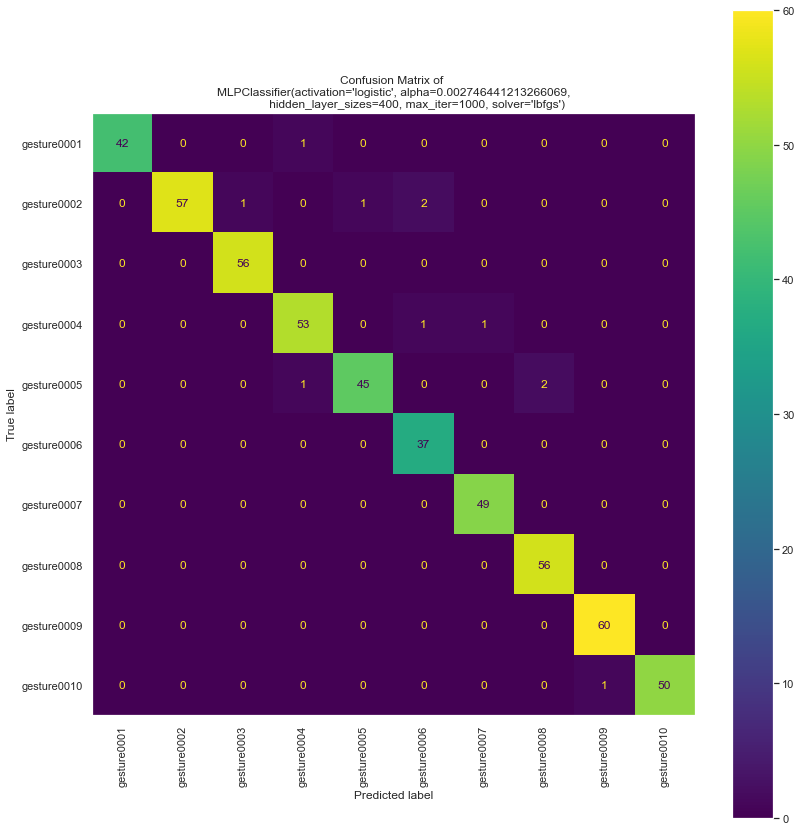

In [14]:
clf = clfs[0]
y_pred = clf.predict(X_test)
clf_name = f'{str(type(clf))}'.split('.')[-1][:-2]

# print(f"Test set results for {clf_name}")
# print(classification_report(y_test, y_pred, target_names=gesture_to_idx.keys()))

fig, ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(
    clf, 
    X_test,
    y_test, 
    display_labels=gesture_to_idx.keys(), 
    xticks_rotation="vertical",
    ax=ax,
)
ax.grid(False)
plt.title(f'Confusion Matrix of \n{clf}')
plt.tight_layout()

plt.savefig(f'imgs/conf_mat_{clf}.pdf')

## 4.3 Visualise important features

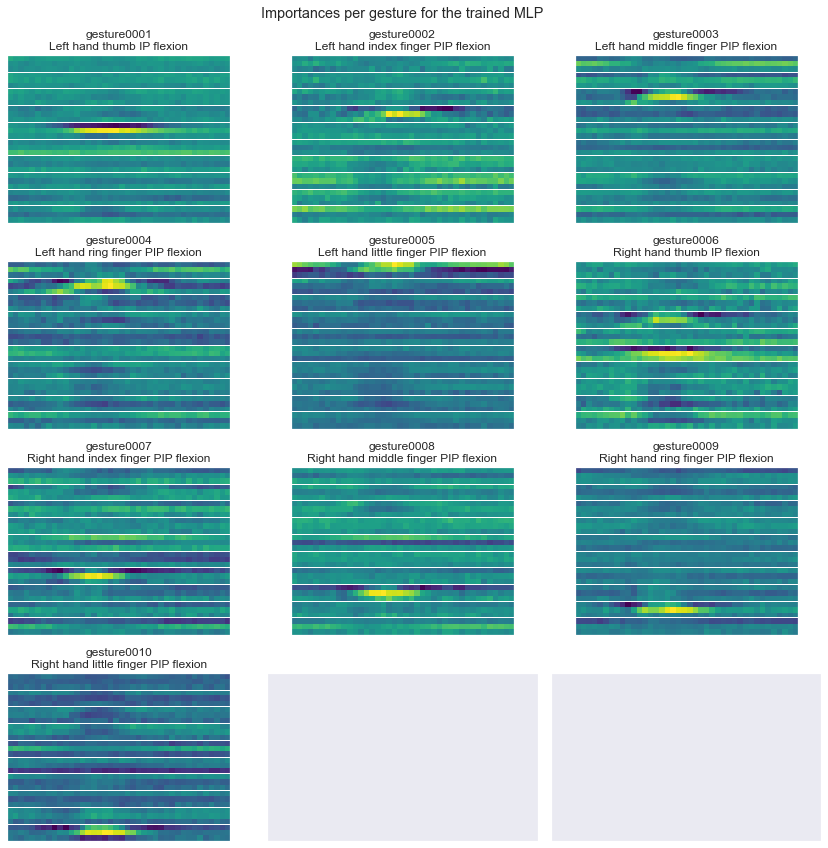

In [16]:
num_cols = 3
fig, axes = plt.subplots(n_classes//num_cols+1, num_cols)
# use global min / max to ensure all weights are shown on the same scale

vmin, vmax = clf.coefs_[0].min(), clf.coefs_[0].max()
for gesture_idx, ax in enumerate(axes.ravel()):
    if gesture_idx >= n_classes:
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        continue
        
    multiplied = clf.coefs_[0]
    for layer in range(1, len(clf.coefs_)):
        multiplied = multiplied @ clf.coefs_[layer]

    importances = multiplied[:, gesture_idx].reshape(n_timesteps, n_sensors)
    
    gesture_label = idx_to_gesture[gesture_idx]
    gesture_description = gesture_info[gesture_label]['description']
    plot_raw_gesture(
        importances.reshape(n_timesteps, n_sensors),
        f'{gesture_label}\n{gesture_description}',
        ax=ax,
        show_cbar=False,
        show_xticks=False,
        show_yticks=False,
        delim_lw=1
    )

plt.suptitle('Importances per gesture for the trained MLP')
plt.tight_layout()
plt.savefig('imgs/importances.pdf')

## 4.4 Plot all incorrectly labelled observations

In [27]:
y_pred = clf.predict(X_test)

X_test_incorrect = X_test[y_pred != y_test]
y_pred_incorrect = y_pred[y_pred != y_test]
y_test_incorrect = y_test[y_pred != y_test]
paths_test_incorrect = paths_test[y_pred != y_test]


@interact(idx=(0, y_pred_incorrect.shape[0]-1, 1))
def plot_incorrect(idx=0):
    predicted = idx_to_gesture[y_pred_incorrect[idx]]
    pred_desc = gesture_info[predicted]['description']
    
    actual = idx_to_gesture[y_test_incorrect[idx]]
    actu_desc = gesture_info[actual]['description']
    
    path = '/'.join(paths_test_incorrect[idx].split('/')[3:])
    
    # Create 3 vertical axs:
    # - top is an example of the actual gesture, 
    # - middle is the incorrectly predicted gesture,
    # - bottom is an example of the predicted gesture
    fig, axs = plt.subplots(1, 3)
    
    # First plot an example of the actual gesture
    actual_idx = next(i for i, yi in enumerate(y_train) if yi == y_pred_incorrect[idx])
    gesture_label = idx_to_gesture[y_train[actual_idx]]
    gesture_description = gesture_info[idx_to_gesture[y_train[actual_idx]]]["description"]
    plot_raw_gesture(
        X_train[actual_idx], 
        f'Actual {gesture_label}\n{gesture_description}',
        ax=axs[0],
        show_xticks=False,
#         show_yticks=False,
        show_cbar=False,
    )

    # Second plot the misclassified gesture
    plot_raw_gesture(
        X_test_incorrect[idx], 
        f'Mislabelled\n{paths_test_incorrect[idx].split("/")[-1]}',
        ax=axs[1],
        show_yticks=False,
        show_xticks=False,
        show_cbar=False,
    )
    
    # Last plot an example of the predicted gesture
    predicted_idx = next(i for i, yi in enumerate(y_train) if yi == y_test_incorrect[idx])
    gesture_label = idx_to_gesture[y_train[predicted_idx]]
    gesture_description = gesture_info[idx_to_gesture[y_train[predicted_idx]]]["description"]
    plot_raw_gesture(
        X_train[predicted_idx], 
        f'Predicted {gesture_label}\n{gesture_description}',
        ax=axs[2],
        show_yticks=False,
        show_xticks=False,
        show_cbar=False,
    )
    
    # Finally, tell matplotlib to recompute the layout
    plt.tight_layout()
    print(paths_test_incorrect[idx])

interactive(children=(IntSlider(value=0, description='idx', max=10), Output()), _dom_classes=('widget-interact…

## 4.? Compare self-classified observations with manually classified observations

In [ ]:
mlp

In [ ]:
dir_files_sc = get_dir_files('../gesture_data/self-classified')
gesture = list(dir_files_sc.keys())[0]
file = dir_files_sc[gesture][0]
path = f'../gesture_data/self-classified/{gesture}/{file}'

df = read_to_df(path)
obs = df.to_numpy()
obs_wrapped = np.zeros((1, n_sensors * n_timesteps))
obs_wrapped[0] = obs.flatten()
txd = scaler.transform(obs_wrapped)
plot_raw_gesture(txd[0], f'{gesture}\n{path}')

In [ ]:
scaler.transform(obs_wrapped)

In [ ]:
obs = df.to_numpy()
obs_wrapped = np.zeros((1, n_sensors * n_timesteps))
obs_wrapped[0] = obs.flatten()
prediction = clf.predict_proba(scaler.transform(obs_wrapped))
predictions = []
for i, prob in enumerate(prediction[0]):
    predictions.append((i, prob))
predictions.sort(key=lambda ip: -ip[1])
predictions

## Plot the incorrect observations

## Plot 2-component PCA to assess separation

Define a widget that, given an observation's index, will display the raw sensor measurements. This is
useful for identifying and removing outliers or bad observations.